In [1]:
import matplotlib.pyplot as plt
import h5py
import os
import numpy as np
from spectral_cube import SpectralCube
from matplotlib.ticker import MultipleLocator
from scipy.stats import linregress
from matplotlib.colors import LogNorm
import astropy.io.fits as fits
from astropy.coordinates import ICRS
from astropy import units as units
import matplotlib.cm as cm
import sys
from importlib import reload
import copy
import healpy
from astropy import units as u
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_clean_tot.fits'
                
hdr_chime = fits.getheader(fn)
fdf_chime = fits.getdata(fn)
wcs_chime = WCS(hdr_chime)

In [3]:
fn = ('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_peakRM.fits')
hdr_peak_chime = fits.getheader(fn)
peak_chime = fits.getdata(fn)

In [4]:
fn = ('/srv/nmohamme/data2/WSRT_PI150M_FDF.gal.FITS')
hdr_wsrt150_pI = fits.getheader(fn)
wsrt150_pI = fits.getdata(fn)
wcs_wsrt150 = WCS(hdr_wsrt150_pI)

In [5]:
phiArr_radm2_chime=np.linspace(wcs_chime.wcs_pix2world(1, 1, 0, 1)[2], wcs_chime.wcs_pix2world(1, 1, hdr_chime['NAXIS3'], 1)[2], hdr_chime['NAXIS3'])
phiArr_radm2_wsrt=np.linspace(wcs_wsrt150.wcs_pix2world(1, 1, 0, 1)[2],wcs_wsrt150.wcs_pix2world(1, 1, hdr_wsrt150_pI['NAXIS3'], 1)[2], hdr_wsrt150_pI['NAXIS3'])

In [6]:
from RMutils.util_RM import get_rmsf_planes
freq = np.arange(138e6, 156e6, 9.8e3)
lsq = (3e8/freq)**2
rmsfplanes_out = get_rmsf_planes(lsq, np.arange(-30,30,0.1), fitRMSF=True)
rmsfplanes_out

(array([0.01292213+0.0079658j , 0.01331236+0.00848437j,
        0.01356944+0.0089115j , ..., 0.01368905-0.00924408j,
        0.01356944-0.0089115j , 0.01331236-0.00848437j]),
 array([-60. , -59.9, -59.8, ...,  59.7,  59.8,  59.9]),
 array(3.7269564, dtype=float32),
 array(1))

In [7]:
peak_wsrt = np.empty_like(wsrt150_pI[0])
for i in range(480):
    for j in range(480):
        try:
            peak_wsrt[i, j] = int(wcs_wsrt150.wcs_pix2world(1, 1, np.nanargmax(wsrt150_pI[:, i, j]), 1)[2])
        except ValueError:
            peak_wsrt[i, j] = np.nan


In [12]:
#LOS used across figures in tadpole paper
xhead_chime,         yhead_chime = wcs_chime.celestial.wcs_world2pix(137.08,7.2, 1)
xhead_chime = 103
yhead_chime = 136


xtail_chime,         ytail_chime = wcs_chime.celestial.wcs_world2pix(134,6.6, 1)
xtail_chime = int(xtail_chime)
ytail_chime = int(ytail_chime)

xoff_chime,         yoff_chime = wcs_chime.celestial.wcs_world2pix(135,9.5, 1)
xoff_chime = int(xoff_chime)
yoff_chime = int(yoff_chime)



xhead_wsrt,         yhead_wsrt = wcs_wsrt150.celestial.wcs_world2pix(137.08,7.2, 1)
xhead_wsrt = int(xhead_wsrt)
yhead_wsrt = int(yhead_wsrt)

xtail_wsrt,         ytail_wsrt = wcs_wsrt150.celestial.wcs_world2pix(134,6.6, 1)
xtail_wsrt = int(xtail_wsrt)
ytail_wsrt = int(ytail_wsrt)

xoff_wsrt,         yoff_wsrt = wcs_wsrt150.celestial.wcs_world2pix(135,9.5, 1)
xoff_wsrt = int(xoff_wsrt)
yoff_wsrt = int(yoff_wsrt)

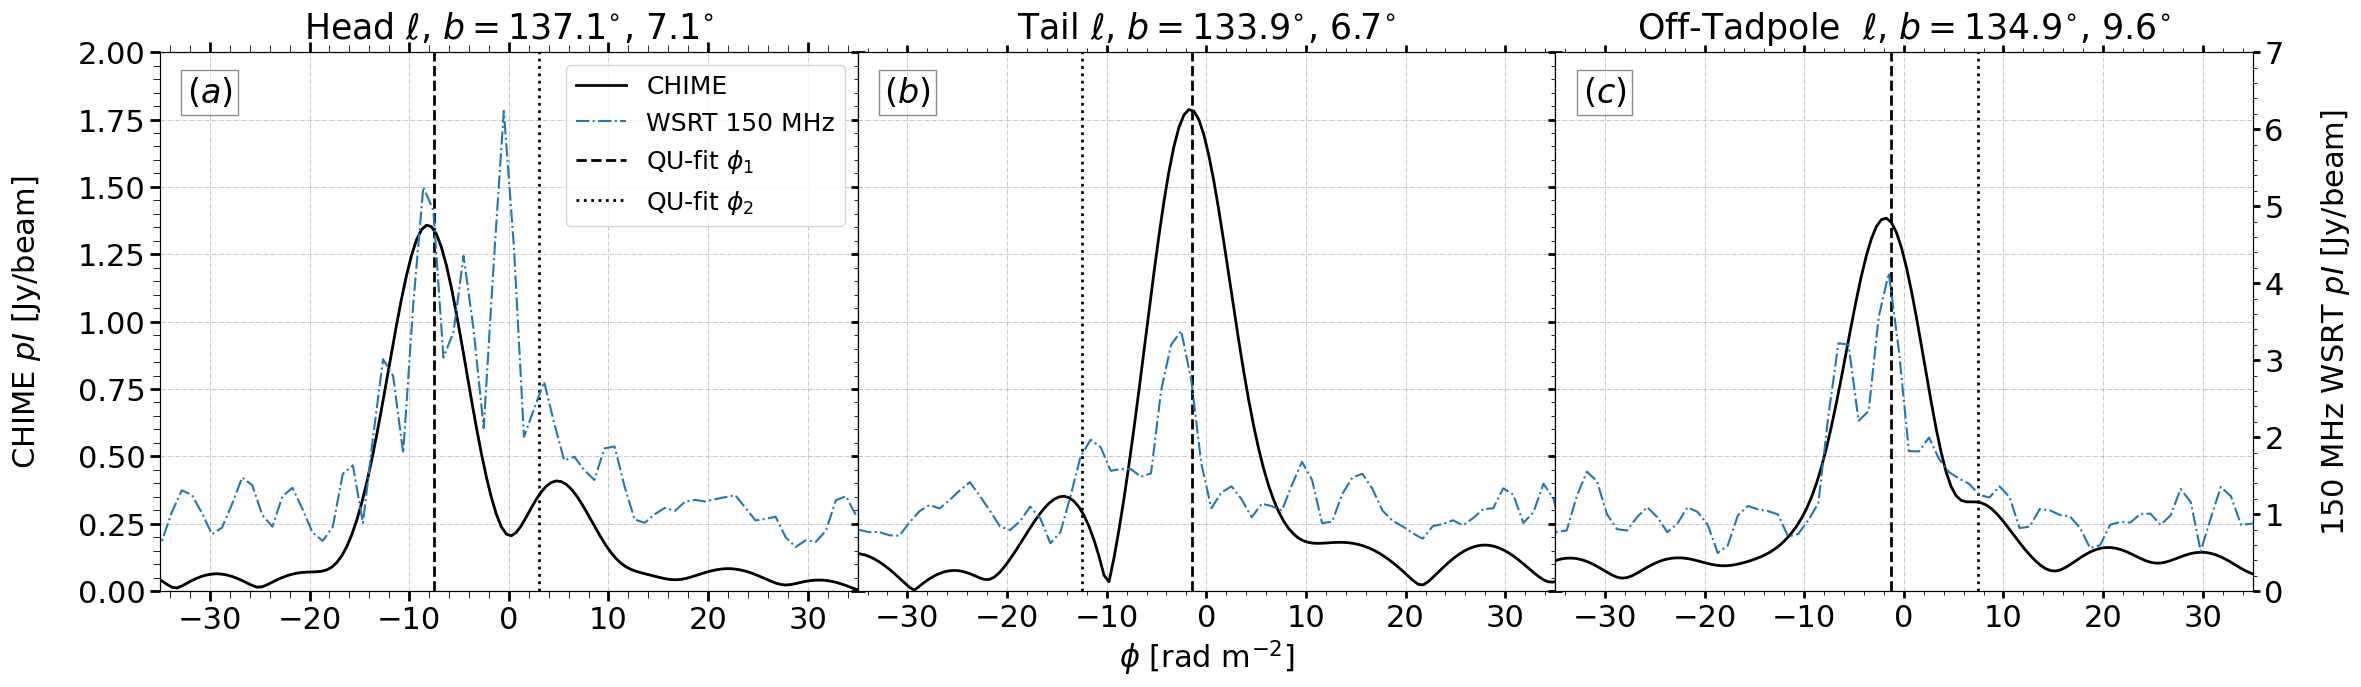

In [14]:
import matplotlib.pyplot as plt

# Create the figure
fig = plt.figure(figsize=(27, 7))


#---------------------------------------------------------------------------------------------------
ax = fig.add_subplot(131)
ax.plot(phiArr_radm2_chime, fdf_chime[:, int(yhead_chime), int(xhead_chime)], label='CHIME', lw=2, c='black', zorder=3)
ax.plot(phiArr_radm2_chime, fdf_chime[:, int(yhead_chime), int(xhead_chime)],c='tab:blue', zorder=0, label='WSRT 150 MHz', ls='-.', )
ax.set_xlim(-35, 35)
ax.set_ylim(0, 2.0)
ax.set_ylabel(r'CHIME $pI$ [Jy/beam]', fontsize=22,labelpad=25)
ax.set_title('Head $\ell$, $b = $137.1$^{\circ}$, 7.1$^{\circ}$', fontsize=25, y=1.01)

ax.minorticks_on() 
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.axvline(-7.5, c='black', linewidth=2, label=r'QU-fit $\phi_1$ ',ls='dashed')
ax.axvline(3 , c='black', linewidth=2, label=r'QU-fit $\phi_2$ ',ls='dotted')
ax.legend(fontsize=18)
ax.text(-30, 1.85,
        r'$(a)$', fontsize=24, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'k'}, ha='center', va='center')
#---------------------
ax2 = ax.twinx()
ax2.set_ylim(0, 7)
ax2.plot(phiArr_radm2_wsrt, wsrt150_pI[:, yhead_wsrt, xhead_wsrt]*1000, ls='-.', c='tab:blue')
ax2.minorticks_on()
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax2.tick_params(axis='both', which='minor', length=3, top=True)
#---------------------------------------------------------------------------------------------------
ax = fig.add_subplot(132)
ax.plot(phiArr_radm2_chime, fdf_chime[:, ytail_chime, xtail_chime], lw=2, c='black', zorder=3)

ax.set_xlim(-35, 35)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\phi$ [rad m$^{-2}$]', fontsize=22)
ax.set_title('Tail $\ell$, $b = $133.9$^{\circ}$, 6.7$^{\circ}$', fontsize=25, y=1.01)
ax.minorticks_on()
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=3, top=True)
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.axvline(-1.4 , c='black', linewidth=2, ls='dashed')
ax.axvline(-12.5, c='black', linewidth=2, ls='dotted')
ax.text(-30, 1.85,
        r'$(b)$', fontsize=24, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'k'}, ha='center', va='center')
#---------------------
ax2 = ax.twinx()
ax2.set_ylim(0, 7)
ax2.plot(phiArr_radm2_wsrt, wsrt150_pI[:, ytail_wsrt, xtail_wsrt]*1000, ls='-.',c='tab:blue')
ax2.minorticks_on() 
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax2.tick_params(axis='both', which='minor', length=3, top=True)
#---------------------------------------------------------------------------------------------------
ax = fig.add_subplot(133)
ax.plot(phiArr_radm2_chime, fdf_chime[:, yoff_chime, xoff_chime], lw=2, c='black', zorder=3)
ax.set_title('Off-Tadpole  $\ell$, $b = $134.9$^{\circ}$, 9.6$^{\circ}$', fontsize=25, y=1.01)
ax.set_xlim(-35, 35)
ax.set_ylim(0, 2)
ax.minorticks_on()
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=3, top=True)
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.axvline(-1.3, c='black', linewidth=2, ls='dashed')
ax.axvline(7.4 , c='black', linewidth=2, ls='dotted')
ax.text(-30, 1.85,
        r'$(c)$', fontsize=24, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'k'}, ha='center', va='center')
#---------------------
ax2 = ax.twinx()
ax2.set_ylim(0, 7)
ax2.plot(phiArr_radm2_wsrt, wsrt150_pI[:, yoff_wsrt, xoff_wsrt]*1000, ls='-.', c='tab:blue')
ax2.set_ylabel(r'150 MHz WSRT $pI$ [Jy/beam]', fontsize=22,labelpad=25)

ax2.minorticks_on() # Enable minor ticks for the third subplot's twin axis
ax2.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax2.tick_params(axis='both', which='minor', length=3, top=True)


fig.subplots_adjust(wspace=0.000)
#plt.savefig('/srv/nmohamme/notebooks/Fall2023/Paper_update/figures_Mar2024/fig7.pdf', bbox_inches='tight', pad_inches=0.1)